In [1]:
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import grad, jit, vmap
from jax import random
import jax

from typing import Sequence
from jaxtyping import Array, Float, Int, PyTree

import equinox as eqx
import optax
import chex

import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

from dataclasses import dataclass
from functools import partial

jax.devices()

jax.enable_checks = True

2023-05-22 12:33:30.708884: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# list requirements
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

jax==0.4.6
equinox==0.10.3
optax==0.1.4
chex==0.1.7
tensorflow==2.12.0
tensorflow_datasets==4.9.2


In [3]:
NUM_EPOCHS = 100
BATCH_SIZE = 256
BUFFER_SIZE = 1024
STEPS_PER_EPOCH = 100
LEARNING_RATE = 0.01
N_TRAINING_SAMPLES = 8 * 1024
N_TEST_SAMPLES = 4096


In [4]:
@eqx.filter_jit
def value_and_jacrev(f, x):
    # Function that computes both the values and the Jacobian using reverse mode autodiff
    y, vjpfun = jax.vjp(f, x)  # Compute the values and obtain a VJP function
    basis = jnp.eye(y.size, dtype=y.dtype)
    jac = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function
    return y, jac, vjpfun

@eqx.filter_jit
def value_and_jacobian(f, x):
    y, jac, _ = value_and_jacrev(f, x)
    return y, jac

In [5]:
def bachPrice(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return  vol * jnp.sqrt(T) * (d * norm.cdf(d) + norm.pdf(d))

def bachDelta(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return norm.cdf(d)

def bachVega(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return jnp.sqrt(T) * norm.pdf(d)
#
    
# generates a random correlation matrix
def genCorrel(key, n):
    randoms = random.uniform(key, shape=(2*n, n), minval=-1., maxval=1.)
    cov = randoms.T @ randoms
    invvols = jnp.diag(1. / jnp.sqrt(jnp.diagonal(cov)))
    return jnp.linalg.multi_dot([invvols, cov, invvols])

            
# training set: returns S1 (mxn), C2 (mx1) and dC2/dS1 (mxn)
@partial(jit, static_argnums=(0,1,2,3,4,5,6,7,8))
def trainingSet(n, m, T1 = 1.0, T2 = 2.0, K = 1.10, volMult = 1.5, anti=True, seed=2, bktVol=0.2):

    key = random.PRNGKey(seed)

    # spots all currently 1, without loss of generality
    S0 = jnp.repeat(1., n)
    # random correl
    key, subkey = random.split(key)
    corr = genCorrel(subkey, n)

    # random weights
    key, subkey = random.split(key)
    a = random.uniform(subkey, shape=(n,), minval=1., maxval=10.)
    a /= jnp.sum(a)
    # random vols
    key, subkey = random.split(key)
    vols = random.uniform(subkey, shape=(n,), minval=5., maxval=50.)
    # normalize vols for a given volatility of basket, 
    # helps with charts without loss of generality
    avols = (a * vols).reshape((-1,1))
    v = jnp.sqrt(jnp.linalg.multi_dot([avols.T, corr, avols]).reshape(1))
    vols = vols * bktVol / v
    bktVol = bktVol

    # Choleski etc. for simulation
    diagv = jnp.diag(vols)
    cov = jnp.linalg.multi_dot([diagv, corr, diagv])
    chol = jnp.linalg.cholesky(cov) * jnp.sqrt(T2 - T1)
    # increase vols for simulation of X so we have more samples in the wings
    chol0 = chol * volMult * jnp.sqrt(T1 / (T2 - T1))
    # simulations
    key, subkey = random.split(key)
    normals = random.normal(subkey, shape=(2, m, n))
    inc0 = normals[0, :, :] @ chol0.T
    inc1 = normals[1, :, :] @ chol.T

    S1 = S0 + inc0

    def func(X, inc1):
        print(X.shape, inc1.shape)
        S2 = X + inc1
        bkt2 = jnp.dot(S2, a)
        pay = jnp.maximum(0, bkt2 - K)

        # two antithetic paths
        # if anti:
        if False:
            
            S2a = X - inc1
            bkt2a = jnp.dot(S2a, a)
            paya = jnp.maximum(0, bkt2a - K)
            
            Y = 0.5 * (pay + paya)

            # # differentials
            # Z1 =  jnp.where(bkt2 > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
            # Z2 =  jnp.where(bkt2a > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
            # Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            Y = pay
            
            # # differentials
            # Z =  jnp.where(bkt2 > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
        return Y

    Y, Z = jax.vmap(jax.value_and_grad(func, argnums=0))(S1, inc1)
    ddYddX = jax.vmap(jax.hessian(func, argnums=0))(S1, inc1)
    
    X = S1
    return X, Y.reshape(-1,1), Z, ddYddX, a

# test set: returns an array of independent, uniformly random spots 
# with corresponding baskets, ground true prices, deltas and vegas
def testSet(n, a, T1 = 1.0, T2 = 2.0, K = 1.10, bktVol = 0.2, lower=0.5, upper=1.50, num=4096, seed=42):
    
    key = random.PRNGKey(seed)
    # adjust lower and upper for dimension
    adj = 1 + 0.5 * jnp.sqrt((n-1)*(upper-lower)/12)
    adj_lower = 1.0 - (1.0-lower) * adj
    adj_upper = 1.0 + (upper - 1.0) * adj
    # draw spots
    key, subkey = random.split(key)
    spots = random.uniform(subkey, shape=(num, n), minval=adj_lower, maxval=adj_upper)
    # compute baskets, prices, deltas and vegas
    baskets = jnp.dot(spots, a).reshape((-1, 1))
    prices = bachPrice(baskets, K, bktVol, T2 - T1).reshape((-1, 1))
    deltas = bachDelta(baskets, K, bktVol, T2 - T1) @ a.reshape((1, -1))
    vegas = bachVega(baskets, K, bktVol, T2 - T1) 
    return spots, baskets, prices, deltas, vegas    

In [9]:
def bachPrice(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return  vol * jnp.sqrt(T) * (d * norm.cdf(d) + norm.pdf(d))

def bachDelta(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return norm.cdf(d)

def bachVega(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return jnp.sqrt(T) * norm.pdf(d)
#
    
# generates a random correlation matrix
def genCorrel(key, n):
    randoms = random.uniform(key, shape=(2*n, n), minval=-1., maxval=1.)
    cov = randoms.T @ randoms
    invvols = jnp.diag(1. / jnp.sqrt(jnp.diagonal(cov)))
    return jnp.linalg.multi_dot([invvols, cov, invvols])


@dataclass(eq=True, frozen=True)
class BachelierParams:
    n_dim: int = 1
    T1: float = 1.0
    T2: float = 2.0
    K: float = 1.10
    test_set_lb = 0.5
    test_set_ub = 1.50
    volMult: float = 1.5
    bktVol: float = 0.2
    anti: bool = True


           
# training set: returns S1 (mxn), C2 (mx1) and dC2/dS1 (mxn)
@partial(jit, static_argnums=(0,1,2,3))
def trainingSet(m: int, params: BachelierParams, seed=2, bktVol=0.2):
    n = params.n_dim
    T1 = params.T1
    T2 = params.T2
    K = params.K
    volMult = params.volMult
    anti = params.anti

    key = random.PRNGKey(seed)

    # spots all currently 1, without loss of generality
    S0 = jnp.repeat(1., n)
    # random correl
    key, subkey = random.split(key)
    corr = genCorrel(subkey, n)

    # random weights
    key, subkey = random.split(key)
    a = random.uniform(subkey, shape=(n,), minval=1., maxval=10.)
    a /= jnp.sum(a)
    # random vols
    key, subkey = random.split(key)
    vols = random.uniform(subkey, shape=(n,), minval=5., maxval=50.)
    # normalize vols for a given volatility of basket, 
    # helps with charts without loss of generality
    avols = (a * vols).reshape((-1,1))
    v = jnp.sqrt(jnp.linalg.multi_dot([avols.T, corr, avols]).reshape(1))
    vols = vols * bktVol / v
    bktVol = bktVol

    # Choleski etc. for simulation
    diagv = jnp.diag(vols)
    cov = jnp.linalg.multi_dot([diagv, corr, diagv])
    chol = jnp.linalg.cholesky(cov) * jnp.sqrt(T2 - T1)
    # increase vols for simulation of X so we have more samples in the wings
    chol0 = chol * volMult * jnp.sqrt(T1 / (T2 - T1))
    # simulations
    key, subkey = random.split(key)
    normals = random.normal(subkey, shape=(2, m, n))
    inc0 = normals[0, :, :] @ chol0.T
    inc1 = normals[1, :, :] @ chol.T

    S1 = S0 + inc0

    def func(X, inc1):
        S2 = X + inc1
        bkt2 = jnp.dot(S2, a)
        pay = jnp.maximum(0, bkt2 - K)

        # two antithetic paths
        # if anti:
        if True:
            
            S2a = X - inc1
            bkt2a = jnp.dot(S2a, a)
            paya = jnp.maximum(0, bkt2a - K)
            
            Y = 0.5 * (pay + paya)
        # standard
        else:
            Y = pay

        return Y

    y, vjpfun = jax.vjp(func, S1, inc1)  # Compute the values and obtain a VJP function
    # basis = jnp.eye(y.size, dtype=y.dtype)
    # jac = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function
    jac = vjpfun(jnp.ones(y.size))[0]

    h = 1e-4
    fd_ph = func(S1 + h, inc1)
    fd_mh = func(S1 - h, inc1)
    fd = (fd_ph - fd_mh) / (2 * h)

    # def cfd(f, h):

    #     def cfd_fn(x, *args):
    #         return (f(x + h, *args) - f(x - h, *args)) / (2 * h)

    #     return cfd_fn

    # cfd_fn = cfd(func, h)
    # cfd_fd = cfd_fn(S1, inc1)

    fdd = (fd_ph - 2 * y + fd_mh) / (h * h)

    # use finite differences to check:
    # h = 1e-4
    jac_fdd_ph = vjpfun(jnp.ones(y.size) + h)[0]
    jac_fdd_mh = vjpfun(jnp.ones(y.size) - h)[0]

    jac_fdd = (jac_fdd_ph - jac_fdd_mh) / (2 * h)

    print("jac is: ")
    print(jac.shape)

    print("y is: ")
    print(y.shape)
    print(y)
    if 0: 
        y, vjpfun = jax.vjp(func, S1, inc1)  # Compute the values and obtain a VJP function
        basis = jnp.eye(y.size, dtype=y.dtype)
        jac = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function
        # return y, jac, vjpfun

        Y = y
        Z = jac

        # Y, Z = jax.vmap(value_and_jacrev(func, argnums=0))(S1, inc1)

    Y, Z = jax.vmap(jax.value_and_grad(func, argnums=0))(S1, inc1)
    print("Y is: ")
    print(Y.shape)
    print(Y)
    jax.debug.print("{val}", val=(Y - y).sum())
    print("Z is: ")
    print(Z.shape)
    jax.debug.print("Diff is: {val}", val=(Z - jac).sum())
    jax.debug.print("Example values: {val1}, {val2}", val1=Z[2,0], val2=jac[2,0])

    ddYddX = jax.vmap(jax.hessian(func, argnums=0))(S1, inc1)
    
    X = S1
    # return X, Y.reshape(-1,1), Z, ddYddX, a
    return X, y.reshape(-1,1), jac, ddYddX, a, fd, fdd, jac_fdd

def testSet(params: BachelierParams, weights, n_samples=4096, seed=42):
    # test set: returns an array of independent, uniformly random spots 
    # with corresponding baskets, ground true prices, deltas and vegas

    n = params.n_dim
    K = params.K
    bktVol = params.bktVol
    T1 = params.T1
    T2 = params.T2
    lower = params.test_set_lb
    upper = params.test_set_ub
    
    key = random.PRNGKey(seed)
    # adjust lower and upper for dimension
    adj = 1 + 0.5 * jnp.sqrt((n-1)*(upper-lower)/12)
    adj_lower = 1.0 - (1.0-lower) * adj
    adj_upper = 1.0 + (upper - 1.0) * adj
    # draw spots
    key, subkey = random.split(key)
    spots = random.uniform(subkey, shape=(n_samples, n), minval=adj_lower, maxval=adj_upper)
    # compute baskets, prices, deltas and vegas
    baskets = jnp.dot(spots, weights).reshape((-1, 1))
    prices = bachPrice(baskets, K, bktVol, T2 - T1).reshape((-1, 1))
    deltas = bachDelta(baskets, K, bktVol, T2 - T1) @ weights.reshape((1, -1))
    vegas = bachVega(baskets, K, bktVol, T2 - T1) 
    return spots, baskets, prices, deltas, vegas   



In [10]:
bachelier_params = BachelierParams(n_dim=1)
X, Y, Z, W, weights, fd, fdd, jac_fd = trainingSet(10 * N_TRAINING_SAMPLES, bachelier_params, seed=42)

def info(X, Y, Z, W, fd, jac_fd):
    print(X.shape)
    print(Y.shape)
    print(Z.shape)
    print(W.shape)
    print("FD")
    print(fd.shape)
    print(fd)
    print("JAC_FD")
    print(jac_fd)

# info(X, Y, Z, W, fd, jac_fd)

spots, baskets, prices, deltas, vegas = testSet(bachelier_params, weights, n_samples=10 * N_TEST_SAMPLES)
# print(spots.shape)

jac is: 
(81920, 1)
y is: 
(81920,)
Traced<ShapedArray(float32[81920])>with<DynamicJaxprTrace(level=1/0)>
Y is: 
(81920,)
Traced<ShapedArray(float32[81920])>with<DynamicJaxprTrace(level=1/0)>
Z is: 
(81920, 1)
0.0
Diff is: 0.0
Example values: 0.5, 0.5


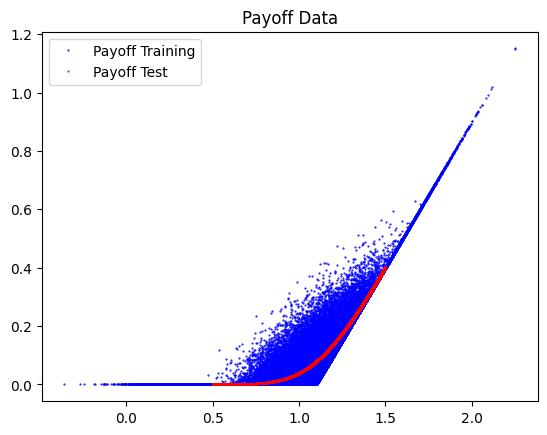

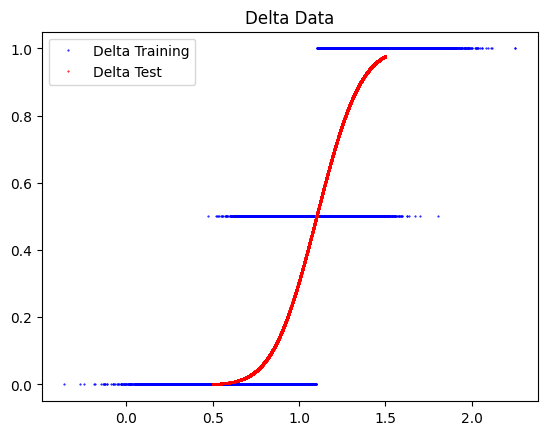

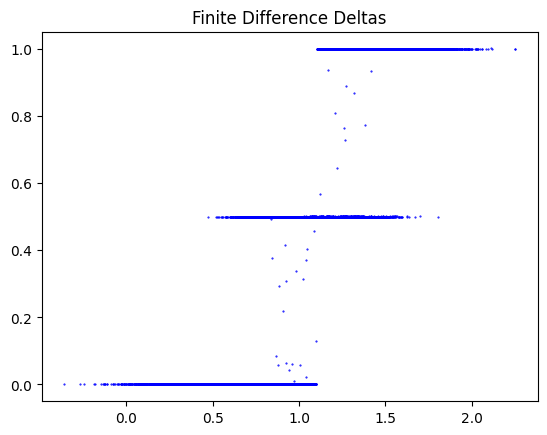

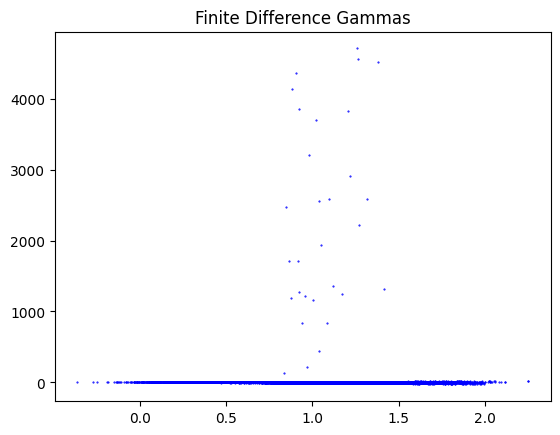

In [11]:
def plot_payoff_data(x_train, y_train, x_test, y_test):
    plt.title("Payoff Data")
    plt.plot(x_train, y_train, 'b.', label='Payoff Training', markersize=1)
    plt.plot(x_test, y_test, 'r.', label='Payoff Test', markersize=1)
    plt.legend()
    plt.show()

def plot_delta_data(x_train, x_test, dydx_train, dydx_test):
    plt.title("Delta Data")
    plt.plot(x_train, dydx_train, 'b.', label='Delta Training', markersize=1)
    plt.plot(x_test, dydx_test, 'r.', label='Delta Test', markersize=1)
    plt.legend()
    plt.show()

plot_payoff_data(X[:,0], Y[:,0], baskets[:, 0], prices[:,0])
plot_delta_data(X[:,0], baskets[:, 0], Z[:,0], deltas[:,0])

plt.title("Finite Difference Deltas")
plt.plot(X[:,0], fd, 'b.', label='FD', markersize=1)
plt.show()

plt.title("Finite Difference Gammas")
plt.plot(X[:,0], fdd, 'b.', label='FD', markersize=1)
plt.show()

In [486]:
bachelier_params = BachelierParams(n_dim=7)
X, Y, Z, W, weights, fd, fdd, jac_fd= trainingSet(N_TRAINING_SAMPLES, bachelier_params, seed=42)
spots, baskets, prices, deltas, vegas = testSet(bachelier_params, weights, n_samples=N_TEST_SAMPLES)

0.0
Example values: 0.0, 0.0
Diff is: 0.0


In [487]:

print(X.shape)
print(baskets.shape)
print(deltas.shape)
print(Y.shape)

(8192, 7)
(4096, 1)
(4096, 7)
(8192, 1)


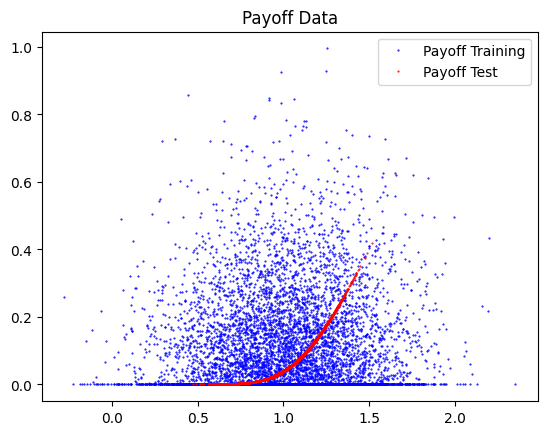

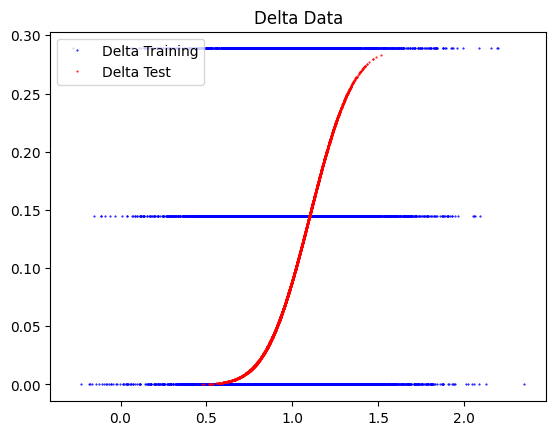

In [488]:
vis_dim = 0
plot_payoff_data(X[:,vis_dim], Y[:,vis_dim], baskets[:, vis_dim], prices[:,vis_dim])
plot_delta_data(X[:,vis_dim], baskets[:, vis_dim], Z[:,vis_dim], deltas[:,vis_dim])

In [489]:
@jit
def normalize(data: Array):
    mean = jnp.mean(data)
    std = jnp.std(data)
    return (data - mean) / std, mean, std

# normalize data
x_train, x_train_mean, x_train_std = normalize(X)
y_train, y_train_mean, y_train_std = normalize(Y)
dydx_train, dydx_train_mean, dydx_train_std = normalize(Z)

In [ ]:
x_train = X
y_train = Y
dydx_train = Z

In [490]:
# Hyperparameters
batch_size = 128
learning_rate = 0.01
num_epochs = 10
seed = 42

key = jax.random.PRNGKey(seed)

In [491]:
def x_normalizer(x):
    return (x - x_train_mean) / x_train_std

def y_denormalizer(x):
    return x * y_train_std + y_train_mean

class MLP_Normalized(eqx.Module):
    layers: list

    def __init__(self, key):
        key, subkey = jax.random.split(key)
        self.layers = [x_normalizer, eqx.nn.MLP(key=subkey, in_size=x_train.shape[1], out_size=y_train.shape[1], width_size=20, depth=3, activation=jax.nn.elu), y_denormalizer]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [492]:
key, subkey = jax.random.split(key)
# model = eqx.nn.MLP(key=subkey, in_size=x_train.shape[1], out_size=y_train.shape[1], width_size=20, depth=3, activation=jax.nn.elu)
model = MLP_Normalized(key)

In [493]:
def trunc_init(weight: Array, key: jax.random.PRNGKey) -> Array:
  out, in_ = weight.shape
  print(out, in_)
  stddev = jnp.sqrt(1 / in_)
  return jax.nn.initializers.glorot_normal()(key, (out, in_))

def init_linear_weight(model, init_fn, key):
  is_linear = lambda x: isinstance(x, eqx.nn.Linear)
  get_weights = lambda m: [x.weight
                           for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                           if is_linear(x)]
  weights = get_weights(model)
  new_weights = [init_fn(weight, subkey)
                 for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]
  new_model = eqx.tree_at(get_weights, model, new_weights)
  return new_model


key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

20 7
20 20
20 20
1 20


In [494]:
def mean_squared_error(y: Float[Array, "n"], pred_y: Float[Array, "n"]) -> Float:
    return jnp.mean((y - pred_y) ** 2)

In [495]:
def loss_fn(model: eqx.nn.MLP, x: Float[Array, "batch"], y: Float[Array, "batch"]) -> Float:
    pred_y = vmap(model)(x)
    chex.assert_type([pred_y], float)
    result = mean_squared_error(y, pred_y)
    chex.assert_type([result], float)
    return result

In [480]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))

x_test = spots
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

generator_train_ds = tfds.as_numpy(train_dataset)
generator_test_ds = tfds.as_numpy(test_dataset)

In [481]:
def train(model: eqx.nn.MLP,
          x: Float[Array, "n"],
          y: Float[Array, "n"],
          optim: optax.GradientTransformation
          ) -> PyTree:
    
    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP,
                   opt_state: PyTree,
                   x: Float[Array, "batch"],
                   y: Float[Array, "batch"]
                   ):
        loss_value, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    for epoch in range(NUM_EPOCHS):
        for step, (batch_x, batch_y, batch_dydx) in enumerate(generator_train_ds):
            model, opt_state, train_loss = train_step(model, opt_state, batch_x, batch_y)

            if (step % 100 == 0):
                test_loss = loss_fn(model, x_test, y_test)
                print('Finished epoch {:3d}'.format(epoch), 
                      ' | Train Loss: {:.5f}'.format(train_loss),
                      ' | Test Loss: {:.5f}'.format(test_loss))

    return model

In [482]:
optim = optax.adam(learning_rate)
model = train(model, x_train, y_train, optim)

Finished epoch   0  | Train Loss: 2.34455  | Test Loss: 0.08176
Finished epoch   1  | Train Loss: 0.11742  | Test Loss: 12.82602
Finished epoch   2  | Train Loss: 0.08877  | Test Loss: 13.43374
Finished epoch   3  | Train Loss: 0.08662  | Test Loss: 15.05608
Finished epoch   4  | Train Loss: 0.08466  | Test Loss: 15.31830
Finished epoch   5  | Train Loss: 0.08422  | Test Loss: 15.26467
Finished epoch   6  | Train Loss: 0.08398  | Test Loss: 14.94968
Finished epoch   7  | Train Loss: 0.08403  | Test Loss: 14.68578
Finished epoch   8  | Train Loss: 0.08422  | Test Loss: 14.53681
Finished epoch   9  | Train Loss: 0.08437  | Test Loss: 14.47816
Finished epoch  10  | Train Loss: 0.08446  | Test Loss: 14.45938
Finished epoch  11  | Train Loss: 0.08452  | Test Loss: 14.44866
Finished epoch  12  | Train Loss: 0.08455  | Test Loss: 14.43705
Finished epoch  13  | Train Loss: 0.08454  | Test Loss: 14.42208
Finished epoch  14  | Train Loss: 0.08450  | Test Loss: 14.40444
Finished epoch  15  | Trai

(4096, 1)
RMSE: 0.005814612377434969


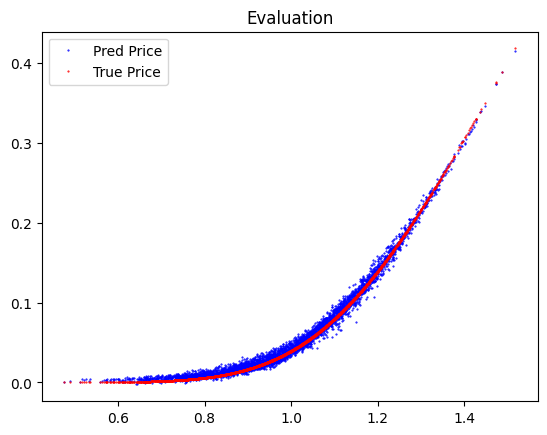

In [483]:
# scaled input
x = (x_test - x_train_mean) / x_train_std
# x = x_test

pred_y = vmap(model)(x)

# unscale predictions
pred_y = pred_y * y_train_std + y_train_mean
print(pred_y.shape)
# evaluate
def eval_rmse(y_true: Array, y_pred: Array) -> Float:
    return jnp.sqrt(mean_squared_error(y_true, y_pred))

print(f"RMSE: {eval_rmse(y_test, pred_y)}")

plt.title("Evaluation")
plt.plot(baskets, pred_y, 'b.', markersize=1)
plt.plot(baskets, y_test, 'r.', markersize=1)
plt.legend(['Pred Price', 'True Price'], loc='upper left')
plt.show()

In [484]:
class MakeScalar(eqx.Module):
    model: eqx.Module

    def __call__(self, *args, **kwargs):
        out = self.model(*args, **kwargs)
        return jnp.reshape(out, ())

RMSE: 0.005814612377434969


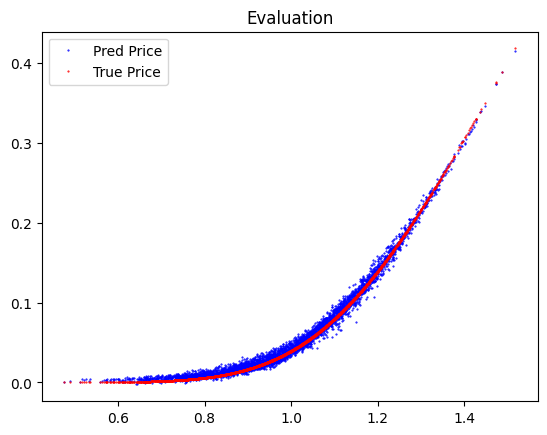

RMSE 0.03899552673101425


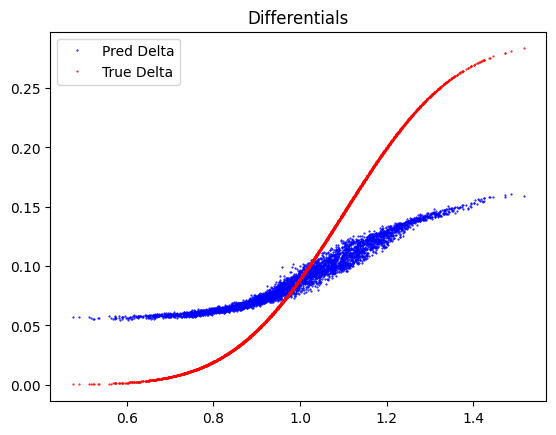

In [485]:
x = (x_test - x_train_mean) / x_train_std

pred_y, pred_dydx = vmap(eqx.filter_value_and_grad(MakeScalar(model)))(x)

# unscale predictions
pred_y = pred_y * y_train_std + y_train_mean
pred_dydx = pred_dydx * dydx_train_std + dydx_train_mean

pred_y = pred_y[:, jnp.newaxis]
print(f"RMSE: {eval_rmse(y_test, pred_y)}")

plt.title("Evaluation")
plt.plot(baskets, pred_y, 'b.', markersize=1)
plt.plot(baskets, y_test, 'r.', markersize=1)
plt.legend(['Pred Price', 'True Price'], loc='upper left')
plt.show()


deltas_rmse = eval_rmse(dydx_test, pred_dydx)
print(f"RMSE {deltas_rmse}")

plt.title("Differentials")
dydx_idx = 0
plt.plot(baskets, pred_dydx[:, dydx_idx], 'b.', markersize=1)
plt.plot(baskets, dydx_test[:, dydx_idx], 'r.', markersize=1)
plt.legend(['Pred Delta', 'True Delta'], loc='upper left')
plt.show()

(4096, 7)
0.08140333


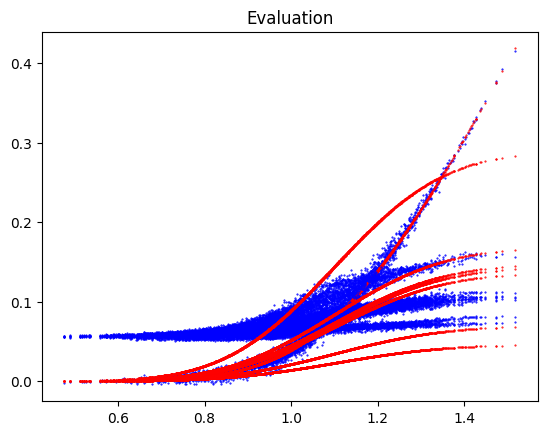

In [266]:
# vmap(eqx.filter_grad(model))(x_test)

# eqx.filter_grad(model)(jnp.array([1.0]))

# eqx.filter_grad(lambda x: model(x))(jnp.array([1.0]))

def eval_fn(x):

    return model(jnp.array([x]))

# fn  = jax.grad(eval_fn)
# vmap(fn)(x_test)

# vmap(jax.grad(eval_fn))(x_test)

# vmap(eqx.filter_grad(eval_fn))(x_test)

# # fn  = eqx.filter_grad(model)
# fn(jnp.array([1.0]))
print(x_test.shape)
primals, fn = eqx.filter_vjp(vmap(model), x)

# s = jnp.zeros_like(primals)
s = jnp.ones_like(primals)
# s = s.at[0].set(1.0)

pred_deltas, = fn(s)
res = jax.jacrev(vmap(model))(x_test)
print(res[0, 0, 0, 1] * dydx_train_std + dydx_train_mean)
# print(res.flatten() * dydx_train_std + dydx_train_mean)

primals = primals * y_train_std + y_train_mean
# pred_deltas = vmap(model)(x_test)

pred_deltas = pred_deltas * dydx_train_std +dydx_train_mean
plt.title("Evaluation")
plt.plot(baskets, primals, 'b.', markersize=1)
plt.plot(baskets, y_test, 'r.', markersize=1)
plt.plot(baskets, pred_deltas, 'b.', markersize=1)
plt.plot(baskets, dydx_test, 'r.', markersize=1)
plt.show()

Differential ML

In [162]:
def diff_loss_fn(model: eqx.nn.MLP, x: Float[Array, "batch"], y: Float[Array, "batch"], dydx: Float[Array, "batch"]) -> Float:
    lam = 1
    n_dims = x.shape[1]
    lambda_scale = lam * n_dims
    # alpha = 1.0/(1.0 + lambda_scale)
    # beta = lambda_scale/(1.0 + lambda_scale)

    alpha = 1.0
    beta = 1.0 - alpha
    y_pred, dydx_pred = vmap(eqx.filter_value_and_grad(model))(x)

    y_pred = y_pred[..., jnp.newaxis]
    dydx_pred = dydx_pred
    assert(y_pred.shape == y.shape)
    assert(dydx_pred.shape == dydx.shape)
    loss = alpha * jnp.mean((y_pred - y)**2) + beta * jnp.mean((dydx_pred - dydx)**2)
    return loss

In [163]:
def optimal_step(x: Float):
    h = jnp.sqrt(jnp.finfo(jnp.float32).eps)
    return h * jnp.fabs(x)

In [164]:
# vmap(eqx.filter_grad(model))(x_train)

# eqx.filter_grad(model)(x_train[0])

    
scalar_model = MakeScalar(model)

# print(vmap(model)(x_train))
# print(vmap(scalar_model)(x_train))

res_auto = vmap(eqx.filter_grad(scalar_model))(x_train)

print(res_auto)


h = optimal_step(x_train[0])
# h = vmap(optimal_step)(x_train)

model_fp = vmap(model)(x_train + h)
model_fm = vmap(model)(x_train - h)

res = (model_fp - model_fm) / (2 * h)

print(res)

jnp.allclose(res_auto, res, 1e-3, 1e-2)

# vmap(eqx.filter_grad(scalar_model))(x_train)

[[-0.24330026]
 [ 1.2995667 ]
 [-0.2566281 ]
 ...
 [ 0.09446687]
 [-0.36370552]
 [-0.52609086]]
[-0.24347237  1.2994075  -0.25671187 ...  0.09357417 -0.36352557
 -0.52599007]


Array(False, dtype=bool)

In [184]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))

x_test = baskets
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

generator_train_ds = tfds.as_numpy(train_dataset)
generator_test_ds = tfds.as_numpy(test_dataset)

In [188]:
def train(model: eqx.nn.MLP,
          x: Float[Array, "n"],
          y: Float[Array, "n"],
          optim: optax.GradientTransformation
          ) -> PyTree:
    
    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP,
                   opt_state: PyTree,
                   x: Float[Array, "batch"],
                   y: Float[Array, "batch"],
                   dydx: Float[Array, "batch"]
                   ):
        loss_value, grads = eqx.filter_value_and_grad(diff_loss_fn)(model, x, y, dydx)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    for epoch in range(NUM_EPOCHS):
        for step, (batch_x, batch_y, batch_dydx) in enumerate(generator_train_ds):
            model, opt_state, train_loss = train_step(model, opt_state, batch_x, batch_y, batch_dydx)

            if (step % 100 == 0):
                test_loss = diff_loss_fn(model, x_test, y_test, dydx_test)
                print('Finished epoch {:3d}'.format(epoch), 
                      ' | Train Loss: {:.5f}'.format(train_loss),
                      ' | Test Loss: {:.5f}'.format(test_loss))

    return model

In [186]:
optim = optax.adam(learning_rate)
scalar_model = train(scalar_model, x_train, y_train, optim)

Finished epoch   0  | Train Loss: 0.07549  | Test Loss: 0.57071
Finished epoch   1  | Train Loss: 0.07626  | Test Loss: 0.73750
Finished epoch   2  | Train Loss: 0.07632  | Test Loss: 0.76479
Finished epoch   3  | Train Loss: 0.07622  | Test Loss: 0.76903
Finished epoch   4  | Train Loss: 0.07641  | Test Loss: 0.77362
Finished epoch   5  | Train Loss: 0.07628  | Test Loss: 0.77496
Finished epoch   6  | Train Loss: 0.07622  | Test Loss: 0.77737
Finished epoch   7  | Train Loss: 0.07648  | Test Loss: 0.78045
Finished epoch   8  | Train Loss: 0.07644  | Test Loss: 0.78112
Finished epoch   9  | Train Loss: 0.07683  | Test Loss: 0.78445
Finished epoch  10  | Train Loss: 0.07676  | Test Loss: 0.78268
Finished epoch  11  | Train Loss: 0.07643  | Test Loss: 0.78117
Finished epoch  12  | Train Loss: 0.07659  | Test Loss: 0.78347
Finished epoch  13  | Train Loss: 0.07672  | Test Loss: 0.78443
Finished epoch  14  | Train Loss: 0.07676  | Test Loss: 0.78459
Finished epoch  15  | Train Loss: 0.0767

(4096, 1)


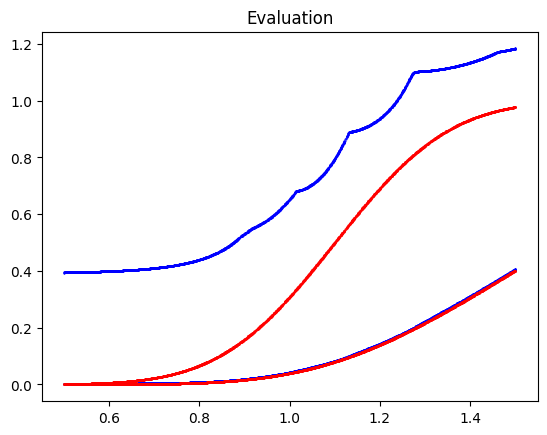

In [187]:
# vmap(eqx.filter_grad(model))(x_test)

# eqx.filter_grad(model)(jnp.array([1.0]))

# eqx.filter_grad(lambda x: model(x))(jnp.array([1.0]))

def eval_fn(x):
    return scalar_model(jnp.array([x]))

# fn  = jax.grad(eval_fn)
# vmap(fn)(x_test)

# vmap(jax.grad(eval_fn))(x_test)

# vmap(eqx.filter_grad(eval_fn))(x_test)

# # fn  = eqx.filter_grad(model)
# fn(jnp.array([1.0]))
print(x_test.shape)
primals, fn = eqx.filter_vjp(vmap(scalar_model), x)

# s = jnp.zeros_like(primals)
s = jnp.ones_like(primals)
# s = s.at[0].set(1.0)

pred_deltas, = fn(s)
# res = jax.jacrev(vmap(model))(x_test)
# print(res[0, 0, 0, 1] * dydx_train_std + dydx_train_mean)
# print(res.flatten() * dydx_train_std + dydx_train_mean)

primals = primals * y_train_std + y_train_mean
# pred_deltas = vmap(model)(x_test)

pred_deltas = pred_deltas * dydx_train_std +dydx_train_mean
plt.title("Evaluation")
plt.plot(x_test, primals, 'b.', markersize=1)
plt.plot(x_test, y_test, 'r.', markersize=1)
plt.plot(x_test, pred_deltas, 'b.', markersize=1)
plt.plot(x_test, dydx_test, 'r.', markersize=1)
plt.show()